# OCR-Based License Plate Recognition (YOLOv8 + Tesseract)

**End-to-end Colab Notebook**
- Downloads Kaggle dataset (Andrew MVD — Car Plate Detection)
- Parses VOC XML → YOLO labels
- Verifies annotations visually
- Trains YOLOv8 (detection)
- Crops plate → Preprocess → OCR with Tesseract
- Generates curves and a final summary

## 1) Setup & Install

In [1]:
!pip install -q ultralytics opencv-python pytesseract kaggle
!sudo apt-get update -y >/dev/null 2>&1
!sudo apt-get install -y tesseract-ocr >/dev/null 2>&1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.9 MB/s eta 0:00:00


## 2) Connect Kaggle & Download Dataset

In [2]:
from google.colab import files
print("➡️ Please upload kaggle.json from your Kaggle account (Account > API > Create New API Token)")
uploaded = files.upload()

import os, zipfile

os.makedirs('/root/.kaggle', exist_ok=True)
if 'kaggle.json' in uploaded:
    with open('/root/.kaggle/kaggle.json', 'wb') as f:
        f.write(uploaded['kaggle.json'])
os.chmod('/root/.kaggle/kaggle.json', 0o600)

!kaggle datasets download -d andrewmvd/car-plate-detection -p /content
!unzip -q /content/car-plate-detection.zip -d /content/car_plate_dataset

DATA_DIR = "/content/car_plate_dataset"
print("✅ Downloaded. Contents:", os.listdir(DATA_DIR))

➡️ Please upload kaggle.json from your Kaggle account (Account > API > Create New API Token)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
License(s): CC0-1.0
 82% 167M/203M [00:00<00:00, 772MB/s] 
100% 203M/203M [00:00<00:00, 747MB/s]
✅ Downloaded. Contents: ['annotations', 'images']


## 3) Imports & Config

In [3]:
import os, random, shutil, json, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pytesseract
import xml.etree.ElementTree as ET

plt.rcParams['figure.figsize'] = (8,4)
DATA_DIR = "/content/car_plate_dataset"
IMAGE_DIR = os.path.join(DATA_DIR, "images")
ANNOT_DIR = os.path.join(DATA_DIR, "annotations")

print("Images:", len(os.listdir(IMAGE_DIR)), "Annotations:", len(os.listdir(ANNOT_DIR)))

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Images: 433 Annotations: 433


## 4) Parse VOC XML Annotations

In [4]:
import pandas as pd

def parse_xml_to_row(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    filename = root.find("filename").text
    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        return [filename, xmin, ymin, xmax, ymax]
    return None

rows = []
for x in sorted(glob.glob(os.path.join(ANNOT_DIR, "*.xml"))):
    row = parse_xml_to_row(x)
    if row: rows.append(row)

df = pd.DataFrame(rows, columns=["filename", "xmin", "ymin", "xmax", "ymax"])
print("✅ Parsed", len(df), "annotations")
df.head()

✅ Parsed 433 annotations


,filename,xmin,ymin,xmax,ymax
0,Cars0.png,226,125,419,173
1,Cars1.png,134,128,262,160
2,Cars10.png,140,5,303,148
3,Cars100.png,175,114,214,131
4,Cars101.png,167,202,240,220


## 5) Dataset Exploration (Simple Stats + Histograms)

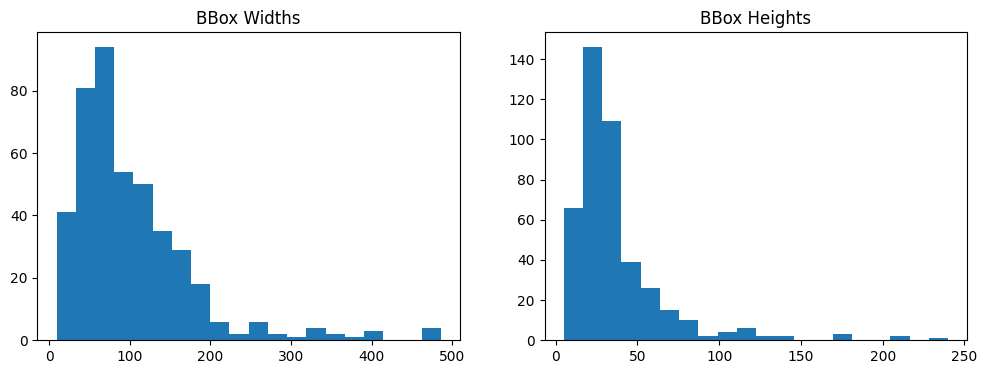

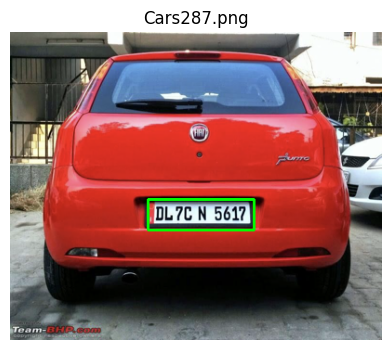

In [5]:
if not df.empty:
    df['w'] = df['xmax'] - df['xmin']
    df['h'] = df['ymax'] - df['ymin']

    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].hist(df['w'], bins=20)
    ax[0].set_title("BBox Widths")
    ax[1].hist(df['h'], bins=20)
    ax[1].set_title("BBox Heights")
    plt.show()

    # Show a random annotated sample
    sample = df.sample(1).iloc[0]
    img = cv2.imread(os.path.join(IMAGE_DIR, sample['filename']))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img_rgb, (sample['xmin'], sample['ymin']), (sample['xmax'], sample['ymax']), (0,255,0), 2)
    plt.imshow(img_rgb); plt.axis('off'); plt.title(sample['filename']); plt.show()
else:
    print("⚠️ No annotations parsed.")

## 6) Convert VOC XML → YOLO TXT Labels

In [6]:
LABEL_DIR = os.path.join(DATA_DIR, "labels")
os.makedirs(LABEL_DIR, exist_ok=True)

def voc_to_yolo_line(img_w, img_h, xmin, ymin, xmax, ymax):
    x_center = ((xmin + xmax) / 2) / img_w
    y_center = ((ymin + ymax) / 2) / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"

count = 0
for xml_path in sorted(glob.glob(os.path.join(ANNOT_DIR, "*.xml"))):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    filename = root.find("filename").text
    img_path = os.path.join(IMAGE_DIR, filename)
    if not os.path.exists(img_path):
        # Some datasets mix jpg/png; try alternate extension
        base, _ = os.path.splitext(filename)
        for ext in [".jpg", ".jpeg", ".png", ".JPG", ".PNG"]:
            alt = os.path.join(IMAGE_DIR, base + ext)
            if os.path.exists(alt):
                img_path = alt
                filename = base + ext
                break
    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    txt_name = os.path.splitext(filename)[0] + ".txt"
    with open(os.path.join(LABEL_DIR, txt_name), "w") as f:
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            f.write(voc_to_yolo_line(w, h, xmin, ymin, xmax, ymax))
            count += 1

print(f"✅ Generated {count} YOLO bbox lines across {len(os.listdir(LABEL_DIR))} label files.")
# Clean any wrong files (e.g., images accidentally in labels)
for f in os.listdir(LABEL_DIR):
    if f.lower().endswith(('.png','.jpg','.jpeg')):
        os.remove(os.path.join(LABEL_DIR, f))
print('🧹 Labels folder cleaned (only .txt left).')

✅ Generated 471 YOLO bbox lines across 433 label files.
🧹 Labels folder cleaned (only .txt left).


## 7) Quick Visual Verification (3 random images)

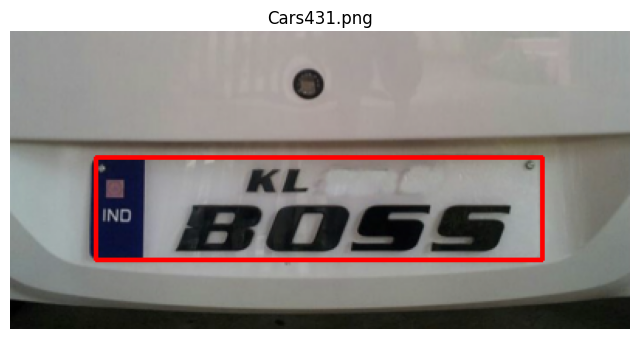

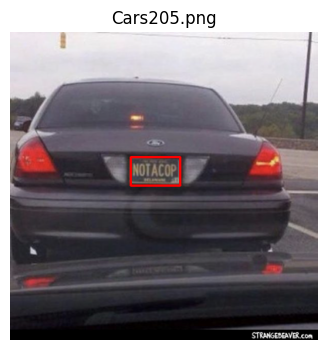

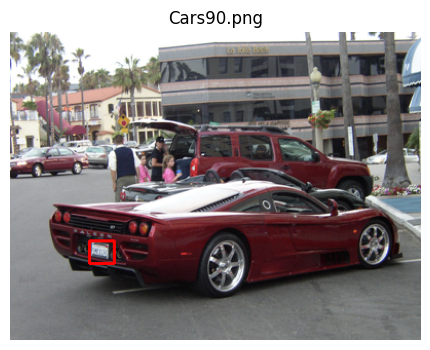

In [7]:
def draw_yolo_boxes(img_path, txt_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    if not os.path.exists(txt_path):
        return img
    with open(txt_path) as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.strip().split())
            x = int((xc - bw/2) * w)
            y = int((yc - bh/2) * h)
            X = int((xc + bw/2) * w)
            Y = int((yc + bh/2) * h)
            cv2.rectangle(img, (x,y), (X,Y), (255,0,0), 2)
    return img

candidates = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.png','.jpg','.jpeg'))]
random.shuffle(candidates)
for name in candidates[:3]:
    img_path = os.path.join(IMAGE_DIR, name)
    txt_path = os.path.join(LABEL_DIR, os.path.splitext(name)[0] + ".txt")
    vis = draw_yolo_boxes(img_path, txt_path)
    plt.imshow(vis); plt.axis('off'); plt.title(name); plt.show()

## 8) Split into Train / Val

In [8]:
for sub in ["train","val"]:
    os.makedirs(os.path.join(IMAGE_DIR, sub), exist_ok=True)
    os.makedirs(os.path.join(LABEL_DIR, sub), exist_ok=True)

images = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.png','.jpg','.jpeg')) and os.path.isfile(os.path.join(IMAGE_DIR,f))]
random.shuffle(images)
split = int(0.8 * len(images))
train_imgs, val_imgs = images[:split], images[split:]

moved = 0
for name in images:
    lbl = os.path.splitext(name)[0] + ".txt"
    src_img = os.path.join(IMAGE_DIR, name)
    src_lbl = os.path.join(LABEL_DIR, lbl)
    if not os.path.exists(src_lbl):
        continue
    dst = "train" if name in train_imgs else "val"
    shutil.move(src_img, os.path.join(IMAGE_DIR, dst, name))
    shutil.move(src_lbl, os.path.join(LABEL_DIR, dst, lbl))
    moved += 1

print(f"✅ Split complete. Moved {moved} pairs.")
print("Train images:", len(os.listdir(os.path.join(IMAGE_DIR,'train'))),
      "Val images:", len(os.listdir(os.path.join(IMAGE_DIR,'val'))))

✅ Split complete. Moved 433 pairs.
Train images: 346 Val images: 87


## 9) Create YOLO Dataset YAML

In [9]:
yaml_text = f"""
path: {DATA_DIR}
train: images/train
val: images/val
nc: 1
names: ['license-plate']
"""
with open("/content/car_plate.yaml","w") as f:
    f.write(yaml_text)

print(open("/content/car_plate.yaml").read())


path: /content/car_plate_dataset
train: images/train
val: images/val
nc: 1
names: ['license-plate']



## 10) Train YOLOv8 (Detection)

In [10]:
model = YOLO("yolov8n.pt")
results = model.train(data="/content/car_plate.yaml", epochs=10, imgsz=640)
print("✅ Training complete. Results at:", results.save_dir)

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/car_plate.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, 

## 11) Training Curves

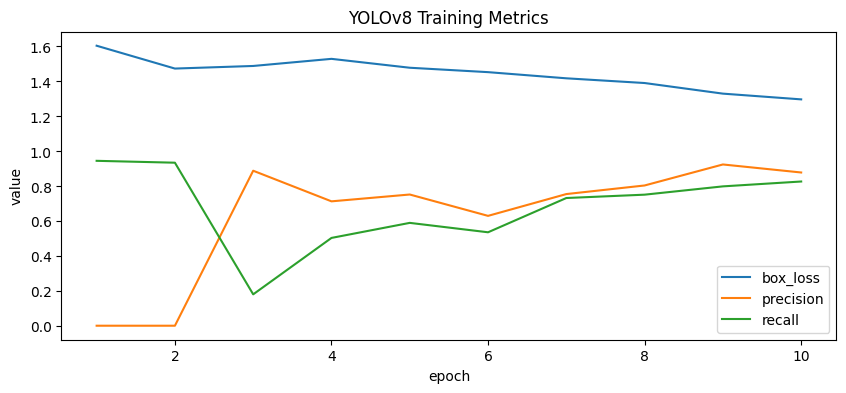

In [11]:
import pandas as pd, glob

csv_paths = glob.glob("/content/runs/detect/*/results.csv")
assert len(csv_paths) > 0, "results.csv not found."
csv_path = sorted(csv_paths)[-1]
dfm = pd.read_csv(csv_path)

plt.figure(figsize=(10,4))
plt.plot(dfm['epoch'], dfm['train/box_loss'], label='box_loss')
if 'metrics/precision(B)' in dfm.columns:
    plt.plot(dfm['epoch'], dfm['metrics/precision(B)'], label='precision')
if 'metrics/recall(B)' in dfm.columns:
    plt.plot(dfm['epoch'], dfm['metrics/recall(B)'], label='recall')
plt.xlabel('epoch'); plt.ylabel('value'); plt.title('YOLOv8 Training Metrics'); plt.legend(); plt.show()

## 12) Inference & Crop Plate Regions

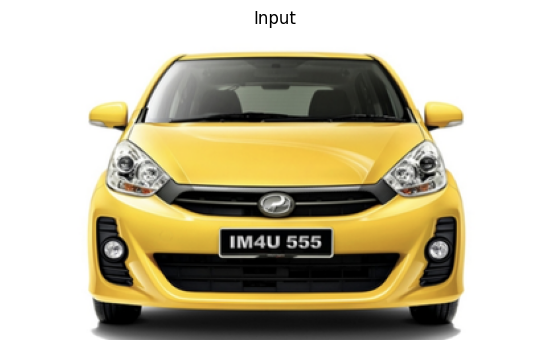

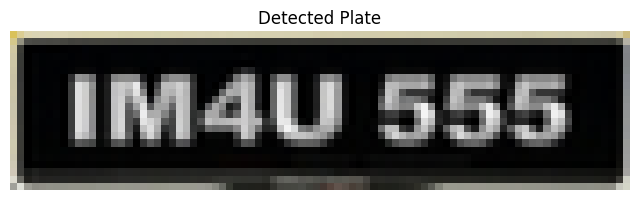

In [12]:
val_dir = os.path.join(IMAGE_DIR, "val")
val_list = [os.path.join(val_dir, f) for f in os.listdir(val_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
assert len(val_list) > 0, "No validation images found."
test_img_path = random.choice(val_list)

img_bgr = cv2.imread(test_img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

pred = model.predict(source=img_rgb, conf=0.4, verbose=False)[0]
boxes = pred.boxes.xyxy.cpu().numpy().astype(int)

plt.imshow(img_rgb); plt.axis('off'); plt.title("Input"); plt.show()
if len(boxes)==0:
    print("⚠️ No plate detected in this image — try another or reduce conf.")
else:
    crops = []
    for (x1,y1,x2,y2) in boxes:
        crop = img_rgb[max(0,y1):y2, max(0,x1):x2]
        if crop.size>0:
            crops.append(crop)
            plt.imshow(crop); plt.axis('off'); plt.title("Detected Plate"); plt.show()

## 13) Preprocess & OCR (Tesseract)

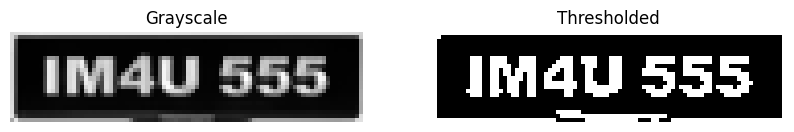

🔤 OCR: cE


In [13]:
def preprocess_for_ocr(crop):
    gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    th = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 11, 2)
    return gray, th

ocr_texts = []
if 'crops' in locals() and len(crops)>0:
    for c in crops:
        g, th = preprocess_for_ocr(c)
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        ax[0].imshow(g, cmap='gray'); ax[0].set_title('Grayscale'); ax[0].axis('off')
        ax[1].imshow(th, cmap='gray'); ax[1].set_title('Thresholded'); ax[1].axis('off')
        plt.show()

        txt = pytesseract.image_to_string(th, config="--psm 8")
        ocr_texts.append(txt.strip())
        print("🔤 OCR:", txt.strip())
else:
    print("⚠️ No crops available for OCR.")

## 14) Final Overlay with OCR Text

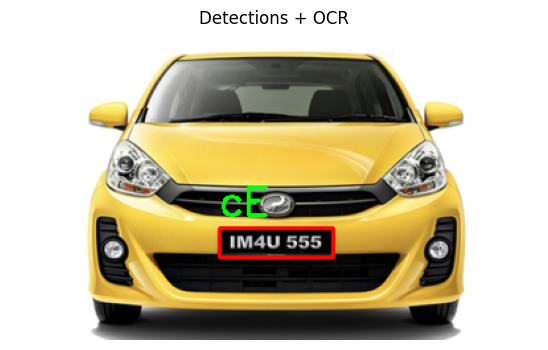

In [14]:
out = img_rgb.copy()
if len(boxes)>0 and len(ocr_texts)>0:
    for (box, txt) in zip(boxes, ocr_texts):
        x1,y1,x2,y2 = box
        cv2.rectangle(out, (x1,y1), (x2,y2), (255,0,0), 2)
        cv2.putText(out, txt, (x1, max(0,y1-10)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

plt.imshow(out); plt.axis('off'); plt.title('Detections + OCR'); plt.show()

## 15) Summary

In [15]:
summary = {
    "train_images": len(os.listdir(os.path.join(IMAGE_DIR,'train'))),
    "val_images": len(os.listdir(os.path.join(IMAGE_DIR,'val'))),
    "model": "YOLOv8n",
    "ocr_engine": "Tesseract",
    "sample_ocr": (ocr_texts[0] if len(ocr_texts)>0 else "N/A")
}
import pandas as pd
pd.DataFrame(summary.items(), columns=['Metric','Value'])

,Metric,Value
0,train_images,346
1,val_images,87
2,model,YOLOv8n
3,ocr_engine,Tesseract
4,sample_ocr,cE


✅ Latest YOLOv8 run directory: /content/runs/detect/train

📈 Training Metrics:


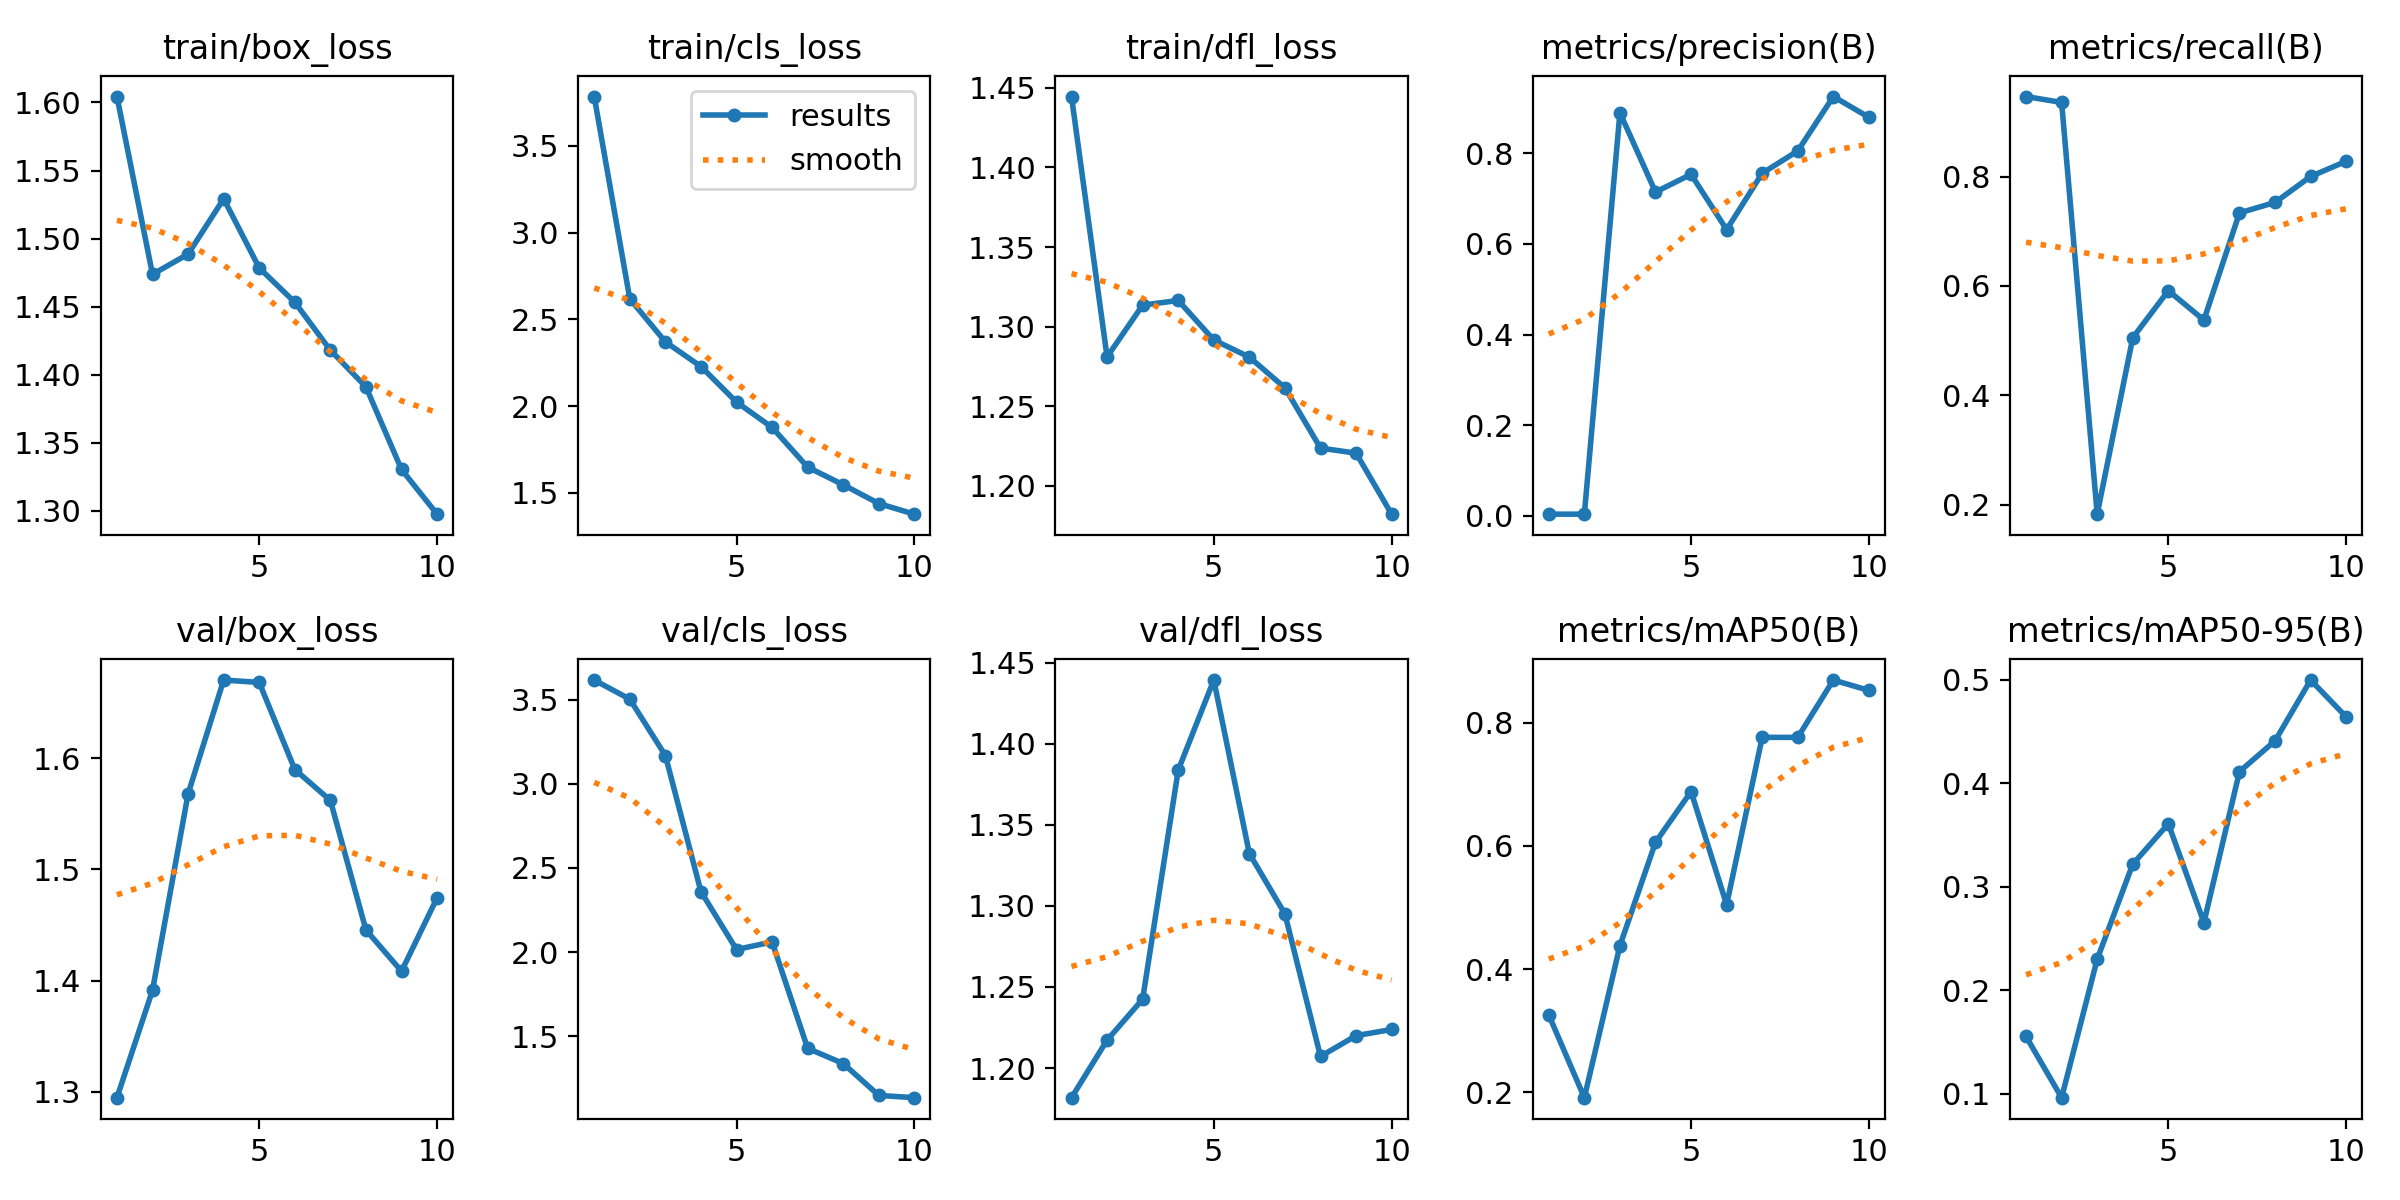


🏷️ Label Distribution Visualization:


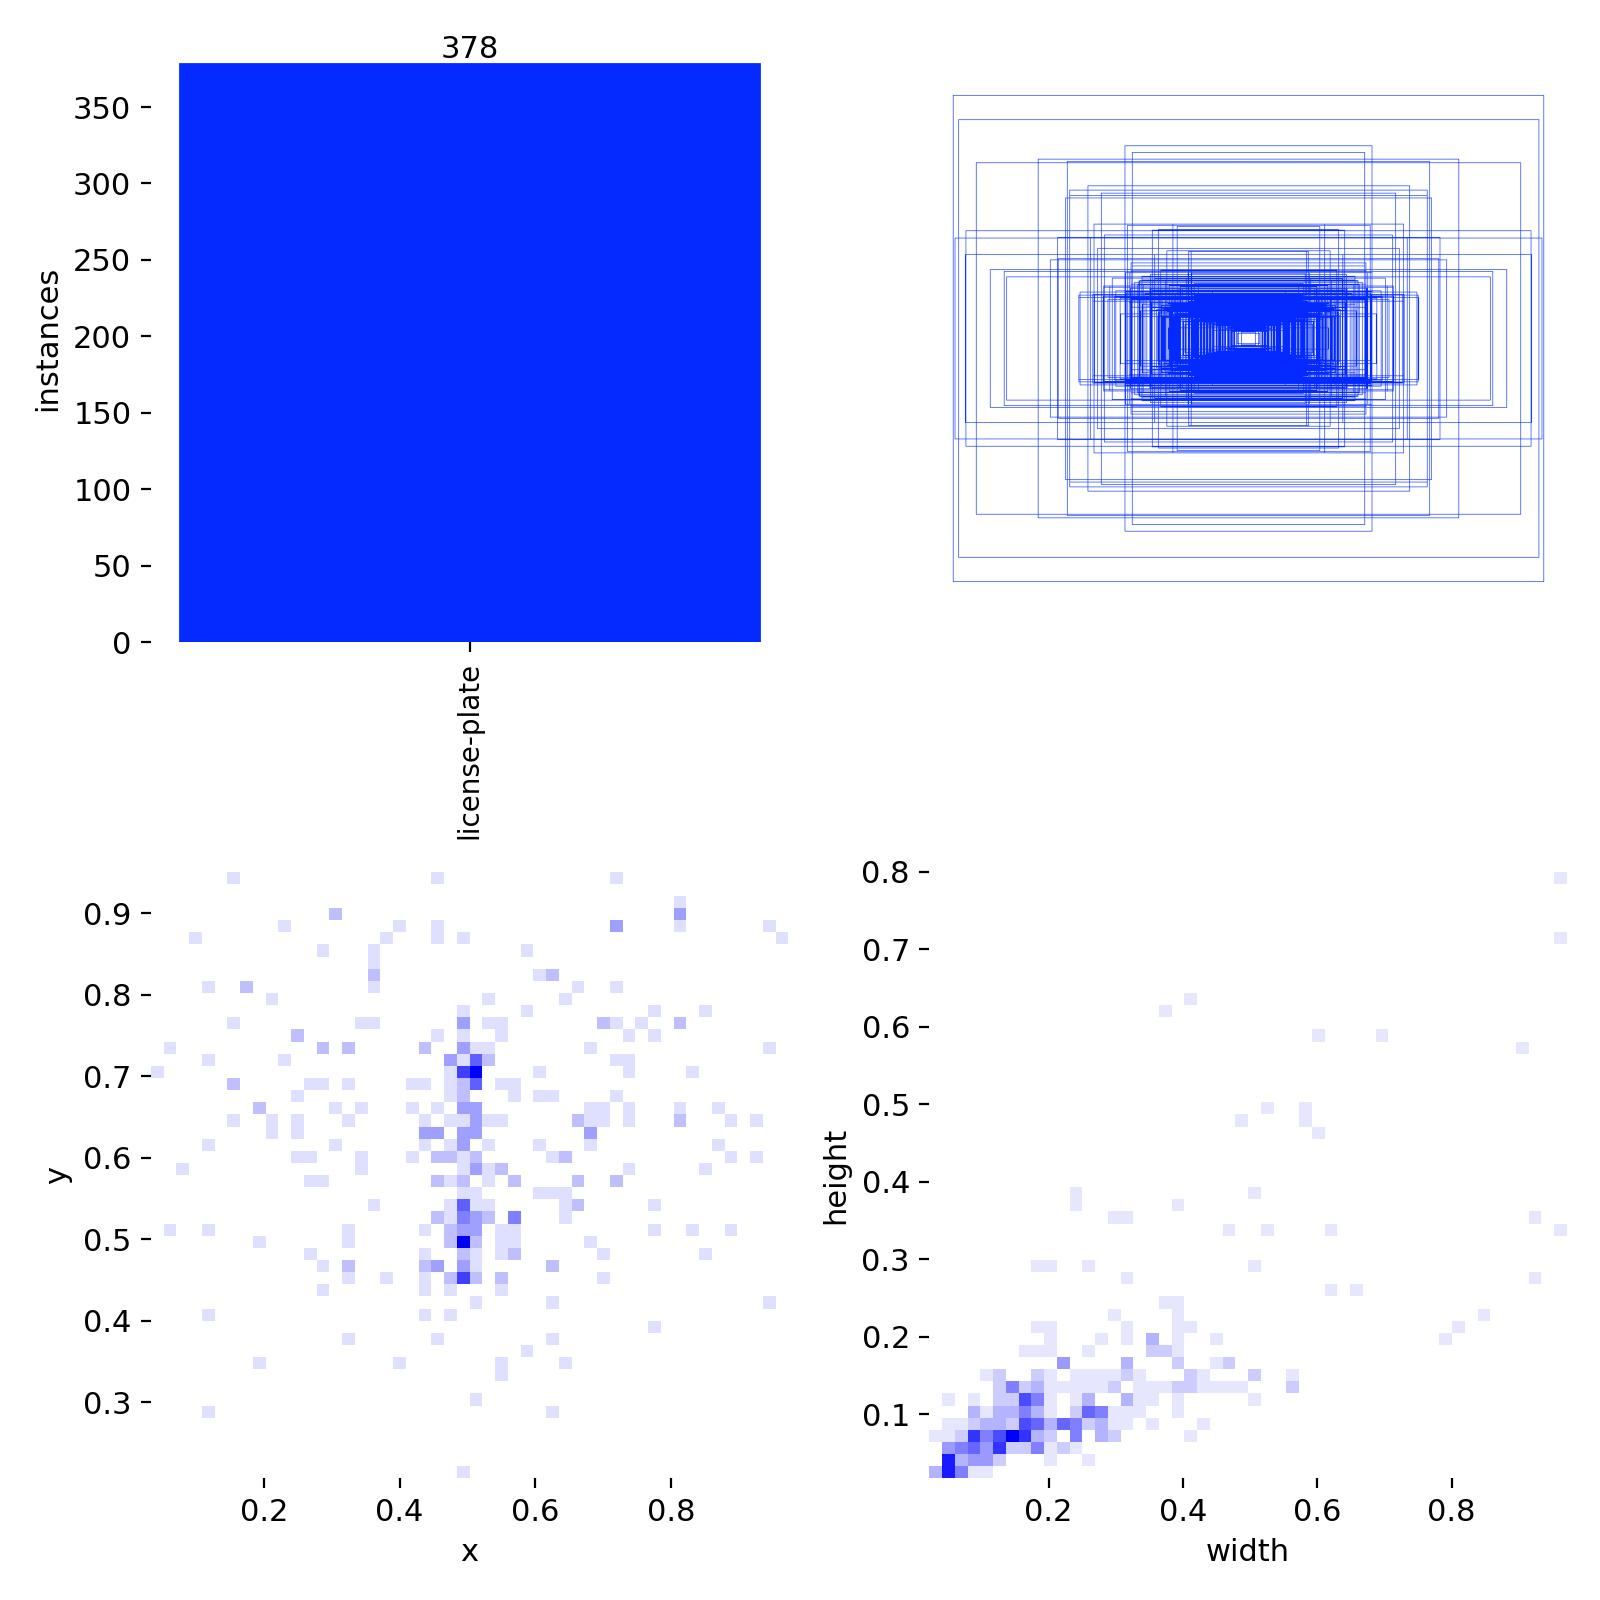


🖼️ Sample Detection Predictions:


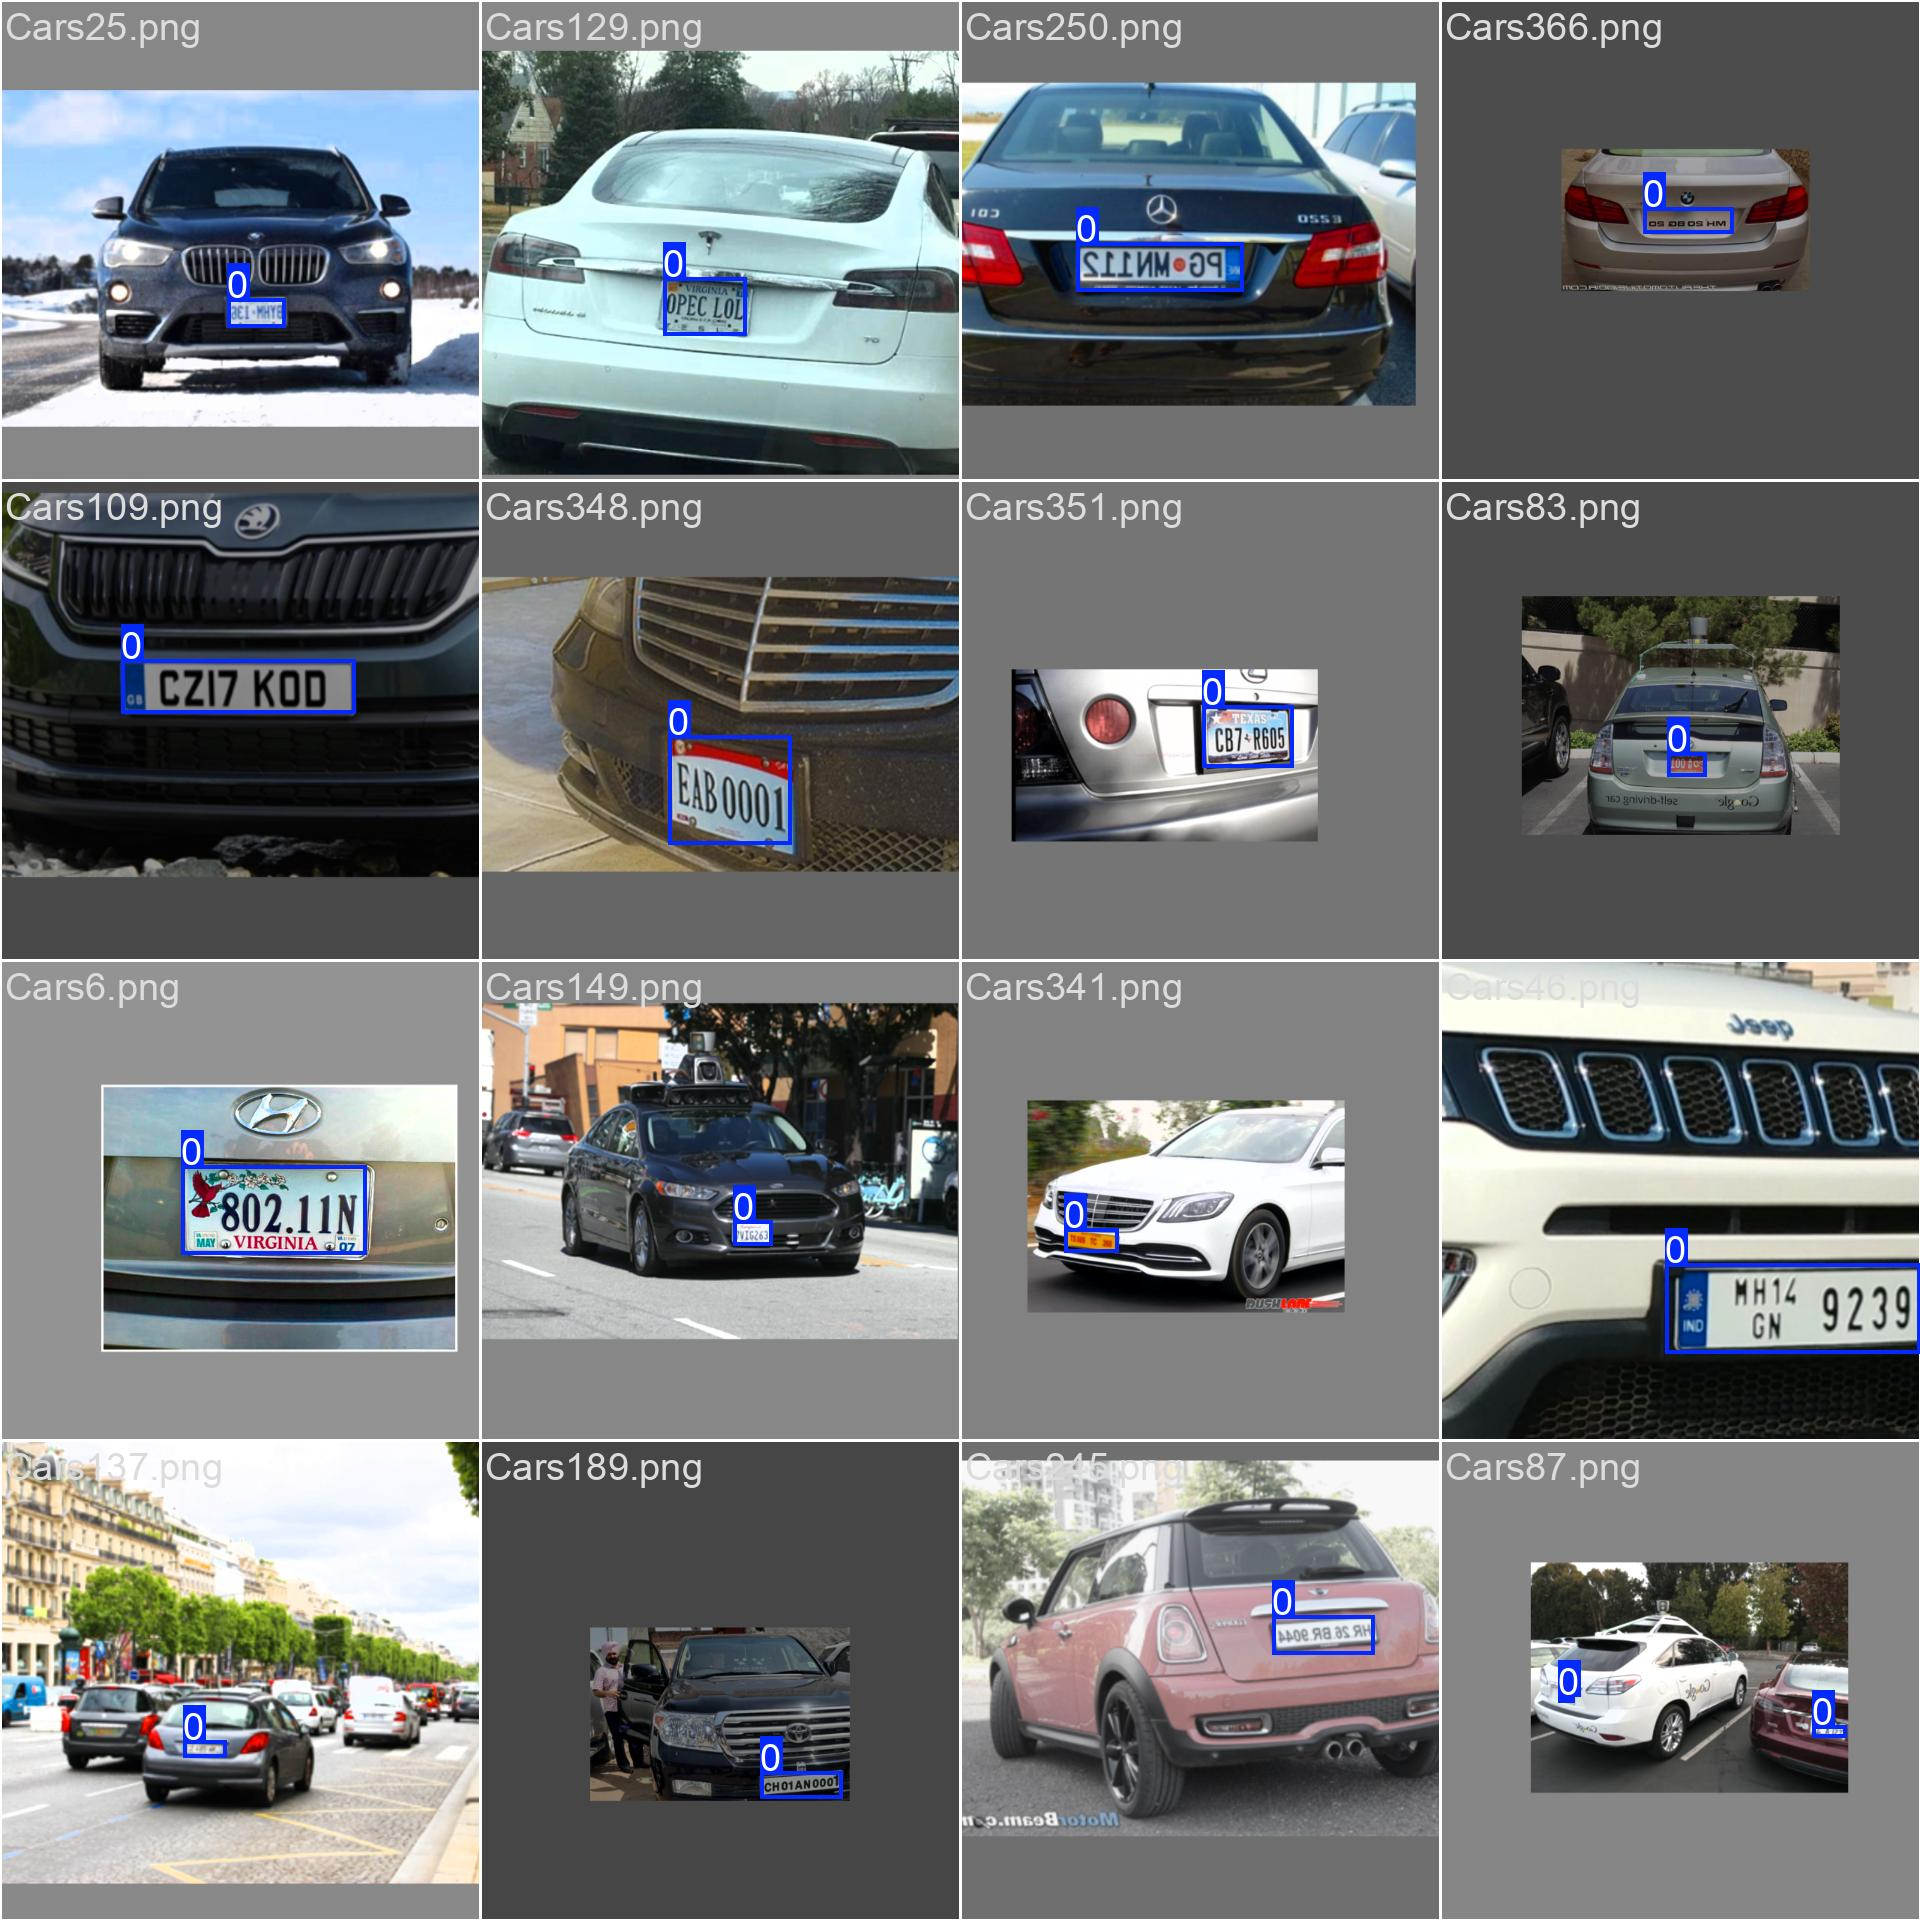


📊 Final Validation Accuracy Metrics (Last Epoch):
   🔹 Precision     : 0.8795
   🔹 Recall        : 0.8280
   🔹 mAP@50        : 0.8527
   🔹 mAP@50–95     : 0.4639


In [17]:
import os
import glob
import pandas as pd
from IPython.display import Image, display

# 🔍 Locate latest YOLOv8 run folder
run_dirs = sorted(glob.glob("/content/runs/detect/*"), key=os.path.getmtime)
latest_run = run_dirs[-1] if run_dirs else None

if latest_run:
    print(f"✅ Latest YOLOv8 run directory: {latest_run}")

    # 📈 Training curves
    results_img = os.path.join(latest_run, "results.png")
    if os.path.exists(results_img):
        print("\n📈 Training Metrics:")
        display(Image(filename=results_img))
    else:
        print("⚠️ Training metrics image not found.")

    # 🏷️ Label distribution
    labels_img = os.path.join(latest_run, "labels.jpg")
    if os.path.exists(labels_img):
        print("\n🏷️ Label Distribution Visualization:")
        display(Image(filename=labels_img))
    else:
        print("⚠️ Label distribution image not found.")

    # 🖼️ Sample training predictions
    train_pred = os.path.join(latest_run, "train_batch0.jpg")
    if os.path.exists(train_pred):
        print("\n🖼️ Sample Detection Predictions:")
        display(Image(filename=train_pred))
    else:
        print("⚠️ Example prediction image not found.")

    # 📊 Accuracy Metrics
    results_csv = os.path.join(latest_run, "results.csv")
    if os.path.exists(results_csv):
        df = pd.read_csv(results_csv)
        final_row = df.iloc[-1]

        precision = final_row.get("metrics/precision(B)", None)
        recall = final_row.get("metrics/recall(B)", None)
        map50 = final_row.get("metrics/mAP50(B)", None)
        map95 = final_row.get("metrics/mAP50-95(B)", None)

        print("\n📊 Final Validation Accuracy Metrics (Last Epoch):")
        print(f"   🔹 Precision     : {precision:.4f}" if precision is not None else "   ⚠️ Precision missing")
        print(f"   🔹 Recall        : {recall:.4f}" if recall is not None else "   ⚠️ Recall missing")
        print(f"   🔹 mAP@50        : {map50:.4f}" if map50 is not None else "   ⚠️ mAP@50 missing")
        print(f"   🔹 mAP@50–95     : {map95:.4f}" if map95 is not None else "   ⚠️ mAP@50–95 missing")
    else:
        print("⚠️ results.csv not found — cannot compute accuracy metrics.")

else:
    print("❌ No YOLOv8 runs found in /content/runs/detect/. Train the model first.")
